# Use `if` condition


## Introduction

This tutorial provides a step-by-step guide on how to implement conditional logic in WorkGraph using two distinct methods:

1. **active_if_zone**
2. **graph_builder Decorator**

## Using the If instruction

WorkGraph provides `active_if_zone` that allows you to define conditional logic in your workflow. The `active_if_zone` block encapsulates all its child tasks, which are executed based on the defined conditions.



### Example

Suppose we want to calculate the following workflow, the tasks for each step are shown:

In [1]:
from aiida_workgraph import task
from aiida import load_profile

load_profile()

@task.calcfunction
def add(x, y):
    return x + y

@task.calcfunction
def multiply(x, y):
    return x*y

# ---------------------------------------------------------
# start the workflow
# step 1
result = add._func(1, 1)
# step 2
if result < 0:
    result = add._func(result, 2)           # use add task
else:
    result = multiply._func(result, 2)      # use multiply task
# step 3
result = add._func(result, 1)
# ---------------------------------------------------------
print("Result is", result)

Result is uuid: ee87fdd5-f023-4169-a9d7-d310e86f21b0 (pk: 61725) value: 5


Use `active_if_zone` to define the conditional logic for the workflow.


In [2]:
from aiida_workgraph import task, WorkGraph, active_graph, active_if_zone

with WorkGraph("if_task") as wg:
    result = add(x=1, y=1)
    with active_if_zone(result < 0):
        wg.ctx.result = add(x=result, y=2)
    with active_if_zone(result >= 0):
        wg.ctx.result = multiply(x=result, y=2)
    #---------------------------------------------------------------------
    result = add(x=wg.ctx.result, y=1)
    # export the workgraph to html file so that it can be visualized in a browser
wg.to_html()
# comment out the following line to visualize the workgraph in jupyter-notebook
# wg

In the GUI, **If** block is shown as a **If Zone** with all its child tasks inside the Zone. 
The if zone have `conditions` socket. Tasks outside the while zone can link to the tasks inside the zone directly.

### Submit the WorkGraph and check the results


In [3]:
wg.run()
print("State of WorkGraph:   {}".format(wg.state))
print('Result   :   {}'.format(result.value))

03/26/2025 09:39:50 PM <775317> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61728|WorkGraphEngine|continue_workgraph]: tasks ready to run: add1,add8
03/26/2025 09:39:50 PM <775317> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61728|WorkGraphEngine|update_task_state]: Task: add1, type: CALCFUNCTION, finished.
03/26/2025 09:39:50 PM <775317> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61728|WorkGraphEngine|continue_workgraph]: tasks ready to run: op_lt2,op_ge5,add8
03/26/2025 09:39:50 PM <775317> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61728|WorkGraphEngine|update_task_state]: Task: op_lt2, type: PyFunction, finished.
03/26/2025 09:39:50 PM <775317> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61728|WorkGraphEngine|continue_workgraph]: tasks ready to run: if_zone3,op_ge5,add8
03/26/2025 09:39:51 PM <775317> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [RE

State of WorkGraph:   FINISHED
Result   :   uuid: 90749b0d-611c-4365-bb71-7e93e8ec189e (pk: 61746) value: 5


Generate node graph from the AiiDA process,and we can see that when `compare1` node outputs `False`, the workgraph stops.

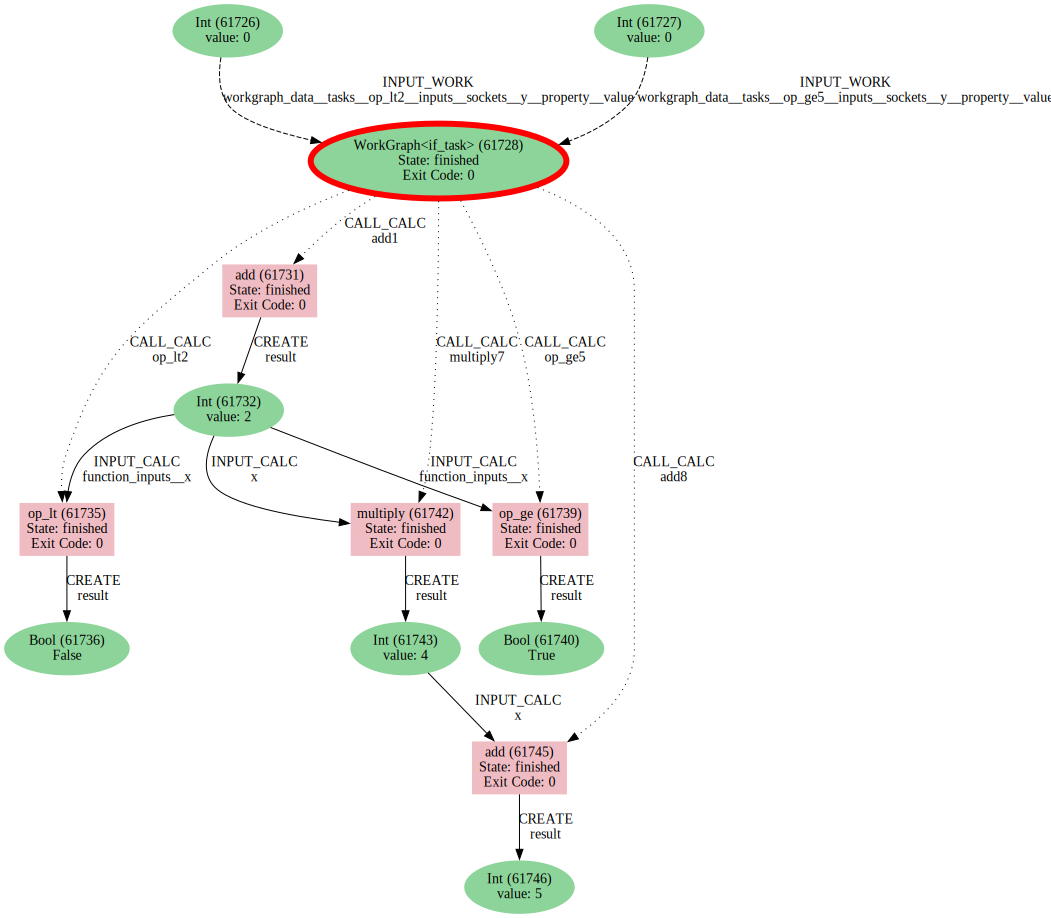

In [4]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Using the graph_builder Decorator

The `graph_builder` decorator is used for creating a dynamic `WorkGraph` during runtime based on input values. This method differs significantly from the `If Task`:

- **Visibility**: In the GUI, only the `graph_builder` task is visible before execution.
- **Dynamic Generation**: Upon running, it generates the WorkGraph dynamically, allowing for complex conditional logic and flow adjustments based on runtime data.



In [5]:
# Create a WorkGraph which is dynamically generated based on the input
# then we output the result of from the context (context)
@task.graph_builder(outputs = [{"name": "result", "from": "ctx.data"}])
def add_multiply_if(x, y):
    wg = WorkGraph()
    if x.value > 0:
        add1 = wg.add_task(add, name="add1", x=x, y=y)
        # export the result of add1 to the context.data
        wg.ctx.data = add1.outputs.result
    else:
        multiply1 = wg.add_task(multiply, name="multiply1", x=x, y=y)
        # export the result of multiply1 to the context.dadta
        wg.ctx.data = multiply1.outputs.result
    return wg

### Create the workflow


In [6]:
from aiida_workgraph import WorkGraph

wg = WorkGraph("if_graph_builer")
add1 = wg.add_task(add, name="add1", x=1, y=1)
add_multiply_if1 = wg.add_task(add_multiply_if, name="add_multiply_if1", x=add1.outputs.result, y=2)
add1 = wg.add_task(add, name="add2", x=add_multiply_if1.outputs.result, y=1)
# export the workgraph to html file so that it can be visualized in a browser
wg.to_html()
# comment out the following line to visualize the workgraph in jupyter-notebook
# wg

In the GUI, we only see the `add_multiply_if1` task. When this task run, it will generate a `WorkGraph` based on the input value. This is different from the `If` task, in which we see all tasks before the WorkGraph run.


### Submit the WorkGraph and check the results


In [7]:
wg.run()
print("State of WorkGraph         : {}".format(wg.state))
print('Result                     : {}'.format(wg.tasks.add2.outputs.result.value))

03/26/2025 09:39:54 PM <775317> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61747|WorkGraphEngine|continue_workgraph]: tasks ready to run: add1
03/26/2025 09:39:54 PM <775317> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61747|WorkGraphEngine|update_task_state]: Task: add1, type: CALCFUNCTION, finished.
03/26/2025 09:39:54 PM <775317> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61747|WorkGraphEngine|continue_workgraph]: tasks ready to run: add_multiply_if1
03/26/2025 09:39:55 PM <775317> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61747|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 61752
03/26/2025 09:39:55 PM <775317> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61752|WorkGraphEngine|continue_workgraph]: tasks ready to run: add1
03/26/2025 09:39:56 PM <775317> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [61752|WorkGraphEn

State of WorkGraph         : FINISHED
Result                     : uuid: d4c55216-6b78-4ce9-b9f1-0be370ca1666 (pk: 61758) value: 5


Generate node graph from the AiiDA process,and we can see that the `multiply` task is executed.

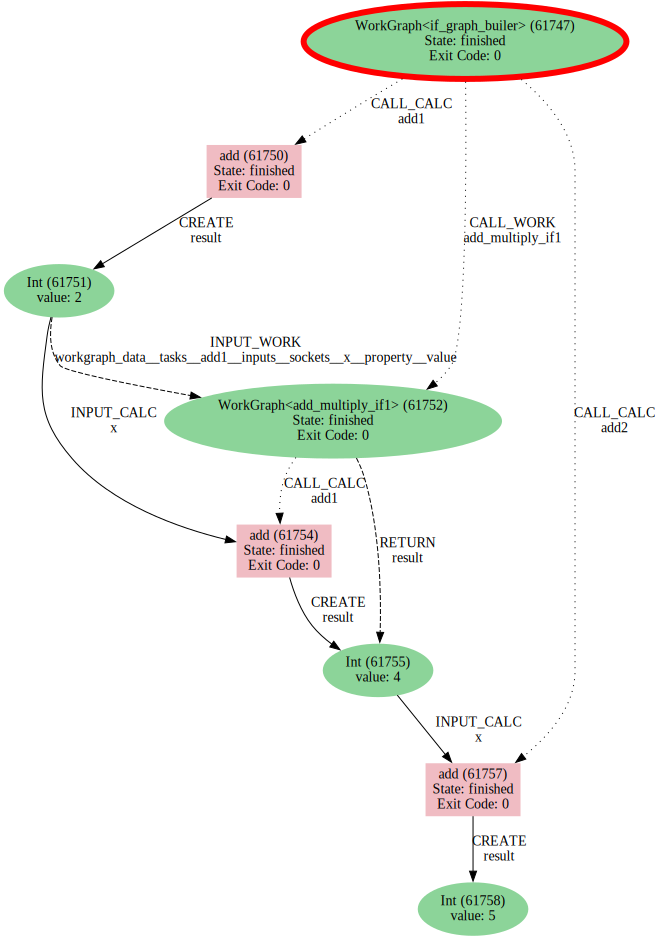

In [8]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## If Task

Internally, the `if_` instruction is implemented using the `If Task` from the WorkGraph library. In the WorkGraph user interface, the `If Task` is visually represented as an "If Zone." This zone encapsulates all its child tasks, which are executed based on the defined conditions.

- **Conditions**: The If Zone includes a `conditions` socket, which determines when the tasks inside the zone should be executed.
- **Invert_condition**: If this input is True, it will invert the conditions.
- **Task Linking**: Tasks located outside the If Zone can be directly linked to tasks within the zone, allowing for dynamic workflow adjustments based on conditional outcomes.

Here is an example of how to add an `If Task` to a WorkGraph:

```python
if2 = wg.add_task("If", name="if_false",
                        conditions=condition1.outputs["result"],
                        invert_condition=True)
```

### Adding tasks to the If Zone
We can add tasks to the `If` zone using the `children` attribute.

```python
# add task1 and task2 to the if zone
if_task.children.add(["task1", "task2"])
```

### Creating the Workflow
To construct the workflow, we'll utilize the built-in `If` and `Select` tasks from the Workgraph library. The `Select` task enables us to choose between two data sources based on a specified condition.

The `Select task has the following inputs:

   - **condition**: Provide the condition that dictates the selection between `true` and `false` outputs.
   - **true**: Specify the output to be used if the condition evaluates to `true`. 
   - **false**: Define the output for when the condition evaluates to `false`.


In [9]:
from aiida_workgraph import task, WorkGraph


with WorkGraph("if_task") as wg:
    condition = add(x=1, y=1)
    if_true_zone = wg.add_task("workgraph.if_zone", name="if_true",
                            conditions=condition)
    add2 = if_true_zone.add_task(add, name="add2", x=condition, y=2)
    if_false_zone = wg.add_task("workgraph.if_zone", name="if_false",
                            conditions=condition,
                            invert_condition=True)
    multiply1 = if_false_zone.add_task(multiply, name="multiply1", x=condition, y=2)
    #---------------------------------------------------------------------
    select1 = wg.add_task("workgraph.select", name="select1", true=add2.outputs["result"],
                        false=multiply1.outputs["result"],
                        condition = condition)
    add3 = wg.add_task(add, name="add3", x=select1.outputs["result"], y=1)
# export the workgraph to html file so that it can be visualized in a browser
wg.to_html()
# comment out the following line to visualize the workgraph in jupyter-notebook
# wg

### Summary

The `active_if_zone` provides a visual and structured approach to managing conditional tasks within a defined zone. In contrast, the `graph_builder` decorator offers flexibility by dynamically generating the workflow based on runtime inputs, suitable for complex and adaptive process flows.
